# Project e-commerce

### Общие положения:
    Необходимо проанализировать совершенные покупки в сфере e-commerce и ответить на некоторые вопросы.
    
### Описание задач:
1. **Узнать, сколько пользователей сервиса совершили покупку только один раз?**
    - Для этого необходимо определить понятие покупки
2. **Определить, сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)**
    - Выяснить возможные причины, по которым доставка может не состояться
3. **По каждому товару определить, в какой день недели он чаще всего покупается.**
    - Определить оптимальный объем представления товаров и наилучшую визуальную форму представления
4. **Выяснить, сколько у каждого из пользователей в среднем покупок в неделю по месяцам?**
    - Не стоит забывать, что внутри месяца может быть не целое количество недель и внутри метрики это необходимо учесть.
5. **Провести когортный анализ пользователей.**
    - В период с января по декабрь выявить когорту с самым высоким retention на 3й месяц
6. **Построить RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время.**
    -  Подробно описать, как создавались кластеры. Для каждого RFM-сегмента построить границы метрик recency, frequency и monetary для интерпретации этих кластеров.
    
### Описание данных: 
#### `orders` - таблица заказов
  - `order_id` —  уникальный идентификатор заказа (номер чека)
  - `customer_id` —  позаказный идентификатор пользователя
  - `order_status` —  статус заказа
  - `order_purchase_timestamp` —  время создания заказа
  - `order_approved_at` —  время подтверждения оплаты заказа
  - `order_delivered_carrier_date` —  время передачи заказа в логистическую службу
  - `order_delivered_customer_date` —  время доставки заказа
  - `order_estimated_delivery_date` —  обещанная дата доставки

#### `items` - товарные позиции, входящие в заказы
  - `order_id` —  уникальный идентификатор заказа (номер чека)
  - `order_item_id` —  идентификатор товара внутри одного заказа
  - `product_id` —  идентификатор-аналог штрихкода товара
  - `seller_id` — идентификатор производителя товара
  - `shipping_limit_date` —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
  - `price` —  цена за единицу товара
  - `freight_value` —  вес товара

#### `customers` - таблица с уникальными идентификаторами пользователей
  - `customer_id` — позаказный идентификатор пользователя
  - `customer_unique_id` —  уникальный идентификатор пользователя (аналог номера паспорта)
  - `customer_zip_code_prefix` —  почтовый индекс пользователя
  - `customer_city` —  город доставки пользователя
  - `customer_state` —  штат доставки пользователя

#### Загрузим необходимые библиотеки и подготовим данные

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import requests
import datetime
import urllib
import json
%matplotlib inline

In [2]:
sns.set(
    font_scale = 2,
    style      ='whitegrid',
    rc         ={'figure.figsize':(15, 10)}
)

In [3]:
token = 'y0_AgAAAABkH2usAArkvAAAAADzLeZcIPD3VRJYR0aKVpmHzVbcJhZ1WMU'
headers = {'Content-Type': 'application/json', 'Accept': 'application/json', 'Authorization': f'OAuth {token}'}

In [4]:
def get_href(folder_url):
    url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?public_key=' + urllib.parse.quote(folder_url)
    r = requests.get(url, headers=headers) # запрос ссылки на скачивание 
    return json.loads(r.text)['href'] # 'парсинг' ссылки на скачивание

In [5]:
date_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']

In [6]:
orders = pd.read_csv(get_href('https://disk.yandex.ru/d/5e8h3LD3LmqQ5g'), parse_dates=date_columns, error_bad_lines=False)

In [7]:
items = pd.read_csv(get_href('https://disk.yandex.ru/d/GnqVnegpx-TnMw'), error_bad_lines=False)

In [8]:
customers = pd.read_csv(get_href('https://disk.yandex.ru/d/FC00jQdKxndwrw'), error_bad_lines=False)

Проведем описательную статистику имеющихся таблиц.

In [9]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [10]:
orders.shape

(99441, 8)

In [11]:
orders.nunique()

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
dtype: int64

In [12]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [13]:
orders.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [14]:
orders.loc[orders.order_status == 'unavailable'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 609 entries, 266 to 99415
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       609 non-null    object        
 1   customer_id                    609 non-null    object        
 2   order_status                   609 non-null    object        
 3   order_purchase_timestamp       609 non-null    datetime64[ns]
 4   order_approved_at              609 non-null    datetime64[ns]
 5   order_delivered_carrier_date   0 non-null      datetime64[ns]
 6   order_delivered_customer_date  0 non-null      datetime64[ns]
 7   order_estimated_delivery_date  609 non-null    datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 42.8+ KB


In [15]:
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [16]:
items.shape

(112650, 7)

In [17]:
items.nunique()

order_id               98666
order_item_id             21
product_id             32951
seller_id               3095
shipping_limit_date    93318
price                   5968
freight_value           6999
dtype: int64

In [18]:
items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [19]:
items.loc[(items.price <= 0)]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value


In [20]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [21]:
customers.shape

(99441, 5)

In [22]:
customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [23]:
customers.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

В таблице `orders` имеется 8 типов статуса заказа. Далее мы будем считать покупку совершенной по наличию времени оплаты в колонке `"order_approved_at"`. За время покупки будем считать время оформления заказа - `order_purchase_timestamp`. По заданному критерию нам подходят колонки: `approved`, `invoiced`, `processing`, `shipped,` `delivered`. Мы не будем брать в расчет статус `"created"`, т.к. заказ еще не оплачен и нет никакой информации о том, что его действительно оплатят. Из вышеуказанных наблюдений мы можем сделать вывод, что статус `"unavailable"`, вероятнее всего, присваивается товарам, которых нет в наличии на складе, т.к. у всех наблюдений отсутствует только время передачи в логистическую службу и время передачи клиенту. В связи с этим, мы не учитываем также заказы со статусом `"canceled"` и `"unavailable"`. Временем покупки будем считать время оформления заказа.
В таблицах `"customers"` и `"items"` никаких аномалий не обнаружено.

In [24]:
#статусы заказов, которые мы считаем купленными
required_statuses = ['delivered', 'invoiced', 'shipped', 'processing', 'approved']

In [25]:
orders.loc[orders.order_status.isin(required_statuses)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98202 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       98202 non-null  object        
 1   customer_id                    98202 non-null  object        
 2   order_status                   98202 non-null  object        
 3   order_purchase_timestamp       98202 non-null  datetime64[ns]
 4   order_approved_at              98188 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97583 non-null  datetime64[ns]
 6   order_delivered_customer_date  96470 non-null  datetime64[ns]
 7   order_estimated_delivery_date  98202 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.7+ MB


Среди оплаченных заказов присутствует 14 записей с отсутствующим значением времени оплаты, что противоречит нашему критерию покупки. Мы не торопимся исключать данные, т.к. в них присутствует время передачи заказчику. Возможно, с подтверждением заказов произошла ошибка, передадим данные об этих заказах коллегам для проверки.

In [26]:
orders.loc[(orders.order_status.isin(required_statuses)) & (orders.order_approved_at.isna())]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
5323,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17
16567,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21
19031,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaT,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17
22663,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31
23156,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20
26800,c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,delivered,2017-01-19 12:48:08,NaT,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01
38290,d69e5d356402adc8cf17e08b5033acfb,68d081753ad4fe22fc4d410a9eb1ca01,delivered,2017-02-19 01:28:47,NaT,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27
39334,d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,delivered,2017-02-18 11:04:19,NaT,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22
48401,7002a78c79c519ac54022d4f8a65e6e8,d5de688c321096d15508faae67a27051,delivered,2017-01-19 22:26:59,NaT,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16
61743,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,delivered,2017-02-17 17:21:55,NaT,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20


## 1)Сколько пользователей сервиса совершили покупку только один раз?

In [27]:
#получаем серию pandas с id купленных заказов
id_uncancelled_orders = orders.loc[orders.order_status.isin(required_statuses)].customer_id 

In [28]:
#находим количество покупателей, которые совершили одну покупку за все время
customers.loc[customers.customer_id.isin(id_uncancelled_orders)] \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'customer_id': 'count'}) \
    .query('customer_id == 1').customer_unique_id.count()

92099

#### 92099 пользователей сервиса совершили покупку только один раз.
(подумать о добавлении графика)

## 2)Сколько заказов в месяц в среднем не доставляется по разным причинам? Вывести детализацию причин.

Как мы ранее заметили, статус `"unavailable"`, вероятнее всего, присваивается товарам, которых нет в наличии на складе из-за отсутствия всего двух значений колонок: времени передачи в логистическую службу и времени передачи клиенту.

In [29]:
undelivered_statuses = ['unavailable', 'canceled']

In [30]:
orders['month'] = orders['order_purchase_timestamp'].dt.strftime('%Y-%m')

In [31]:
undelivered_orders = orders.loc[orders.order_status.isin(undelivered_statuses)]

In [32]:
orders.loc[orders.order_status == 'unavailable'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 609 entries, 266 to 99415
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       609 non-null    object        
 1   customer_id                    609 non-null    object        
 2   order_status                   609 non-null    object        
 3   order_purchase_timestamp       609 non-null    datetime64[ns]
 4   order_approved_at              609 non-null    datetime64[ns]
 5   order_delivered_carrier_date   0 non-null      datetime64[ns]
 6   order_delivered_customer_date  0 non-null      datetime64[ns]
 7   order_estimated_delivery_date  609 non-null    datetime64[ns]
 8   month                          609 non-null    object        
dtypes: datetime64[ns](5), object(4)
memory usage: 47.6+ KB


In [33]:
orders.loc[orders.order_status == 'canceled'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 625 entries, 397 to 99347
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       625 non-null    object        
 1   customer_id                    625 non-null    object        
 2   order_status                   625 non-null    object        
 3   order_purchase_timestamp       625 non-null    datetime64[ns]
 4   order_approved_at              484 non-null    datetime64[ns]
 5   order_delivered_carrier_date   75 non-null     datetime64[ns]
 6   order_delivered_customer_date  6 non-null      datetime64[ns]
 7   order_estimated_delivery_date  625 non-null    datetime64[ns]
 8   month                          625 non-null    object        
dtypes: datetime64[ns](5), object(4)
memory usage: 48.8+ KB


Мы можем определить причину отмены по отсутствующим значениям в следующих полях таблицы:

 - `order_approved_at` - отсутствие подтверждения заказа

 - `order_delivered_carrier_date` - отсутствие времени передачи заказа в логистическую службу

 - `order_delivered_customer_date` - отсутствие времени доставки получателю

 - Если пропущенных значений `нет`, то товар `не подошел`, и его вернули после получения.

При подсчете количества отмененных заказов важно исключить повторяющиеся заказы(если заказ отменен на этапе подтверждения, то у него, соответственно, не будет и времени передачи в логистическую службу и получателю)

In [34]:
orders.loc[orders.order_status == 'unavailable'].head(1)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05,2017-11


Рассмотрим причины отмены заказов и добавим их в таблицу.

In [35]:
columns_with_nan = ['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']

In [36]:
canceled_orders = orders.loc[orders.order_status == 'canceled']

In [37]:
#есть время подтверждения, есть время передачи логистической компании, есть время передачи заказчику
not_fit = canceled_orders.loc[(canceled_orders.order_approved_at.notna()) &
                    (canceled_orders.order_delivered_carrier_date.notna()) & 
                    (canceled_orders.order_delivered_customer_date.notna())]
not_fit = not_fit.assign(cancel_reason='not_fit')

In [38]:
#есть время подтверждения, есть время передачи логистической компании, нет времени передачи заказчику
not_received = canceled_orders.loc[(canceled_orders.order_approved_at.notna()) &
                    (canceled_orders.order_delivered_carrier_date.notna()) &
                    (~ canceled_orders.order_id.isin(not_fit.order_id))]
not_received = not_received.assign(cancel_reason='not_received')

In [39]:
#есть время подтверждения, нет времени передачи логистической компании, нет времени передачи заказчику
not_transferred = canceled_orders.loc[(canceled_orders.order_approved_at.notna()) &
                    (~ canceled_orders.order_id.isin(not_received.order_id)) &
                    (~ canceled_orders.order_id.isin(not_fit.order_id))]
not_transferred = not_transferred.assign(cancel_reason='not_transferred')

In [40]:
#нет времени подтверждения, нет времени передачи логистической компании, нет времени передачи заказчику
not_approved = canceled_orders.loc[(canceled_orders.order_approved_at.isna()) &
                    (~ canceled_orders.order_id.isin(not_transferred.order_id)) &
                    (~ canceled_orders.order_id.isin(not_received.order_id)) &
                    (~ canceled_orders.order_id.isin(not_fit.order_id))]
not_approved = not_approved.assign(cancel_reason='not_approved')

In [41]:
not_available = undelivered_orders.loc[undelivered_orders.order_status == 'unavailable']
not_available = not_available.assign(cancel_reason='not_available')

In [42]:
undelivered_orders_with_reason = pd.concat([not_fit, not_approved, not_received, not_transferred, not_available])

In [43]:
avg_undelivered_orders = undelivered_orders_with_reason \
    .groupby(['cancel_reason', 'month'], as_index=False) \
    .agg({'order_id': 'count'}) \
    .groupby('cancel_reason', as_index=False) \
    .agg({'order_id': 'mean'}) \
    .rename(columns={'order_id': 'avg_count'}) \
    .sort_values('avg_count', ascending=False)

In [44]:
avg_undelivered_orders

,cancel_reason,avg_count
1,not_available,29.000000
4,not_transferred,18.590909
3,not_received,17.250000
0,not_approved,6.714286
2,not_fit,3.000000


 - `not_fit` - товар не подошел. Так же есть вероятность сбоя: заказ, доставленный покупателю мог получить статус "canceled" по ошибке, т.к. в таблице уже имеются записи о получении заказа. Если ошибки все же нет, и товар действительно был возвращен после получения, то необходимо добавить отдельный статус для товаров - `"returned"`
 - `not_received` - будем считать, что покупатель передумал забирать товар, т.к. заказ был передан в логистическую службу, а время получения заказа покупателем(order_delivered_customer_date) - отсутствует.
 - `not_transferred` - заказ подтвержден, но не передан в логистическую службу. Будем считать это ошибкой на их стороне.
 - `not_approved` - заказ отменен на этапе подтверждения. 

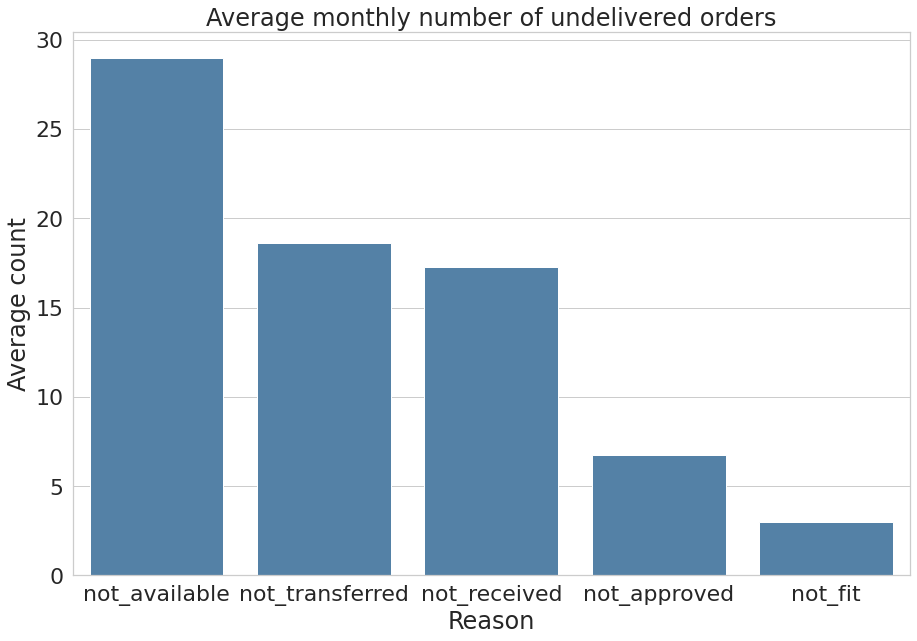

In [45]:
ax = sns.barplot(data=avg_undelivered_orders, x='cancel_reason', y='avg_count', color='steelblue')
#plt.xticks(rotation=90)
ax.set(xlabel='Reason', ylabel='Average count', title='Average monthly number of undelivered orders')
plt.show()

## 3)По каждому товару определить, в какой день недели он чаще всего покупается.

Извлекаем день недели, в который заказ был создан, т.е. оформлен

In [46]:
orders['day_of_week'] = orders['order_purchase_timestamp'].dt.day_name()

Присоединяем колонку дня недели покупки из таблицы заказов к таблице товаров

In [47]:
items_with_dow = items.merge(orders[['order_id', 'day_of_week']], on='order_id', how='left')

Подсчитываем количество купленных товаров для каждого дня недели

In [48]:
items_count = items_with_dow \
    .groupby(['product_id', 'day_of_week'], as_index=False) \
    .agg({'order_id': 'count'}) \
    .rename(columns={'order_id': 'count'}) \
    .sort_values('count', ascending=False)

In [49]:
items_count.head()

,product_id,day_of_week,count
15902,422879e10f46682990de24d770e7f83d,Wednesday,93
36513,99a4788cb24856965c36a24e339b6058,Monday,92
41045,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
41041,aca2eb7d00ea1a7b8ebd4e68314663af,Friday,87
41046,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,85


Избавляемся от повторных позиций путем извлечения максимального количества для каждого товара

In [50]:
purchase_frequency = items_count \
    .pivot(index='product_id', values='count', columns='day_of_week') \
    .idxmax(axis=1) \
    .to_frame() \
    .reset_index() \
    .rename(columns={0: 'day_of_week'}) \
    .merge(items_count, on=['product_id', 'day_of_week']) \
    .sort_values('count', ascending=False)

In [51]:
purchase_frequency.head()

,product_id,day_of_week,count
8613,422879e10f46682990de24d770e7f83d,Wednesday,93
19742,99a4788cb24856965c36a24e339b6058,Monday,92
22112,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
10867,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
7079,368c6c730842d78016ad823897a372db,Friday,67


In [52]:
purchase_frequency.describe(percentiles=[.25, .5, .75, .9, .99])

,count
count,32951.000000
mean,1.673242
std,2.281261
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
90%,3.000000
99%,9.000000
max,93.000000


##### Как мы можем заметить, большую часть товаров покупают в день не более 2 раз. Исходя из этого, нам необходимо определить наиболее подходящее число товаров, чтобы отсеить непопулярные товары.

In [53]:
purchase_frequency.quantile(.99)[0]

9.0

In [54]:
purchase_frequency.loc[purchase_frequency['count'] > purchase_frequency.quantile(.99)[0]].shape[0]

314

##### Всего по 314 позициям покупают более 9 единиц товара в определенный день недели, что составляет 1% от максимального количества приобретенного товара в день.

##### Ниже располагается таблица с 10 лучшими продуктами по продажам с указанием дня продаж.

In [55]:
purchase_frequency.head(10)

,product_id,day_of_week,count
8613,422879e10f46682990de24d770e7f83d,Wednesday,93
19742,99a4788cb24856965c36a24e339b6058,Monday,92
22112,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
10867,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
7079,368c6c730842d78016ad823897a372db,Friday,67
7364,389d119b48cf3043d311335e499d9c6b,Thursday,67
10840,53759a2ecddad2bb87a079a1f1519f73,Wednesday,66
27039,d1c427060a0f73f6b889a5c7c61f2ac4,Monday,64
8051,3dd2a17168ec895c781a9191c1e95ad7,Wednesday,54
21302,a62e25e09e05e6faf31d90c6ec1aa3d1,Thursday,50


In [56]:
#лучший товар для каждого дня недели
purchase_frequency.day_of_week.unique()

array(['Wednesday', 'Monday', 'Thursday', 'Tuesday', 'Friday', 'Saturday',
       'Sunday'], dtype=object)

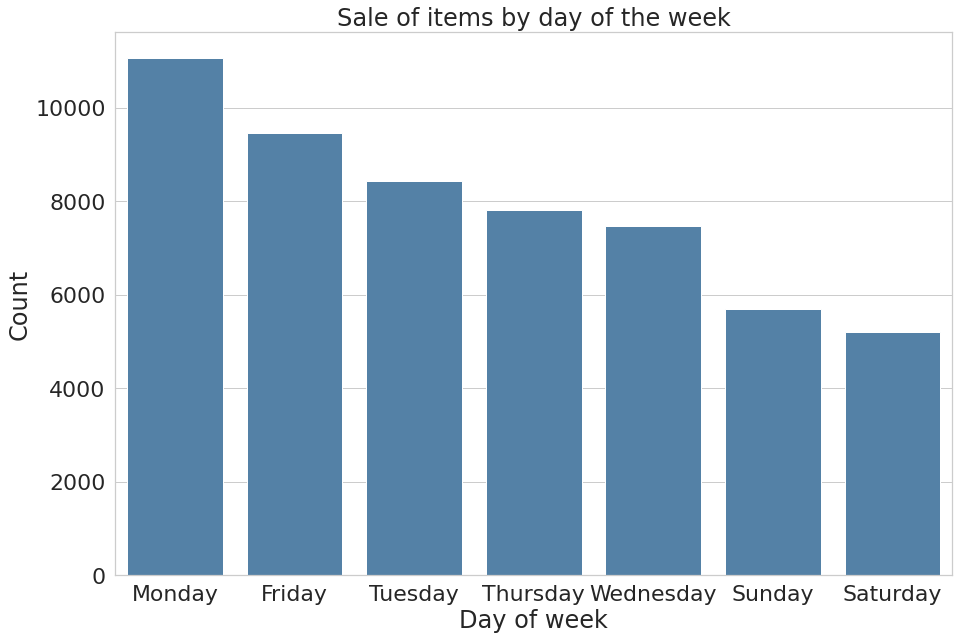

In [57]:
df = purchase_frequency.groupby('day_of_week').agg({'count': 'sum'}).reset_index().sort_values('count', ascending=False)
ax = sns.barplot(data=df, x='day_of_week', y='count', color='steelblue')
ax.set(xlabel='Day of week', ylabel='Count', title='Sale of items by day of the week')
plt.show()

## 4)Выяснить, сколько у каждого из пользователей в среднем покупок в неделю по месяцам?

In [58]:
#примерживаем таблицу покупателей к таблице заказов для дальнейшего определения дня покупки
order_by_week = orders.merge(customers, on='customer_id', how='inner')

In [59]:
order_by_week.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
month                               0
day_of_week                         0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
dtype: int64

In [60]:
order_by_week.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month,day_of_week,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10,Monday,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018-07,Tuesday,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018-08,Wednesday,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017-11,Saturday,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018-02,Tuesday,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


#### Количество уникальных пользователей всего на 3.4% меньше, чем общее количество заказов. Это означает, что пользователи крайне редко обращаются к сервису для повторного заказа товаров. 

In [61]:
#разница между количеством заказов и уникальных пользователей в процентах
np.round((1 - order_by_week.customer_unique_id.nunique() / order_by_week.shape[0]) * 100, 1)

3.4

In [62]:
avg_order_by_week = order_by_week \
    .groupby(['customer_unique_id', 'month'], as_index=False) \
    .agg({'customer_id': 'count'}) \
    .sort_values('customer_id', ascending=False) \
    .rename(columns={'customer_id': 'avg_orders'})

Добавим в таблицу заказов количество недель, чтобы учесть неполные недели месяца. Мы не будем избавляться от пропущенных значений, т.к. они присутствуют только в 3 колонках со временем доставок и подтверждения оплаты, в дате создания заказа их нет.

In [63]:
#вернем номер месяца в тип "datetime", чтобы получить количество дней в месяце
avg_order_by_week['month'] = pd.to_datetime(avg_order_by_week['month'])

In [64]:
avg_order_by_week['week_count'] = avg_order_by_week['month'].dt.daysinmonth / 7

In [65]:
avg_order_by_week['avg_orders'] = avg_order_by_week['avg_orders'] / avg_order_by_week['week_count']

In [66]:
avg_order_by_week.head()

,customer_unique_id,month,avg_orders,week_count
7325,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01-01,1.354839,4.428571
50622,83e7958a94bd7f74a9414d8782f87628,2017-01-01,0.903226,4.428571
76793,c8460e4251689ba205045f3ea17884a1,2018-08-01,0.903226,4.428571
67755,b08fab27d47a1eb6deda07bfd965ad43,2017-09-01,0.933333,4.285714
62196,a239b8e2fbce33780f1f1912e2ee5275,2017-02-01,1.000000,4.000000


In [67]:
avg_order_by_week.describe()

,avg_orders,week_count
count,98046.000000,98046.000000
mean,0.233468,4.348151
std,0.029926,0.124166
min,0.225806,4.000000
25%,0.225806,4.285714
50%,0.225806,4.428571
75%,0.233333,4.428571
max,1.354839,4.428571


In [68]:
avg_order_by_week.loc[avg_order_by_week.avg_orders >= 1]

,customer_unique_id,month,avg_orders,week_count
7325,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01-01,1.354839,4.428571
62196,a239b8e2fbce33780f1f1912e2ee5275,2017-02-01,1.000000,4.000000
69396,b4e4f24de1e8725b74e4a1f4975116ed,2018-02-01,1.000000,4.000000
23943,3e43e6105506432c953e165fb2acf44c,2018-02-01,1.000000,4.000000


#### Из вышеприведенной таблицы мы определили, что всего у 4 покупателей количество среднемесячных покупок составляло 1 или более.

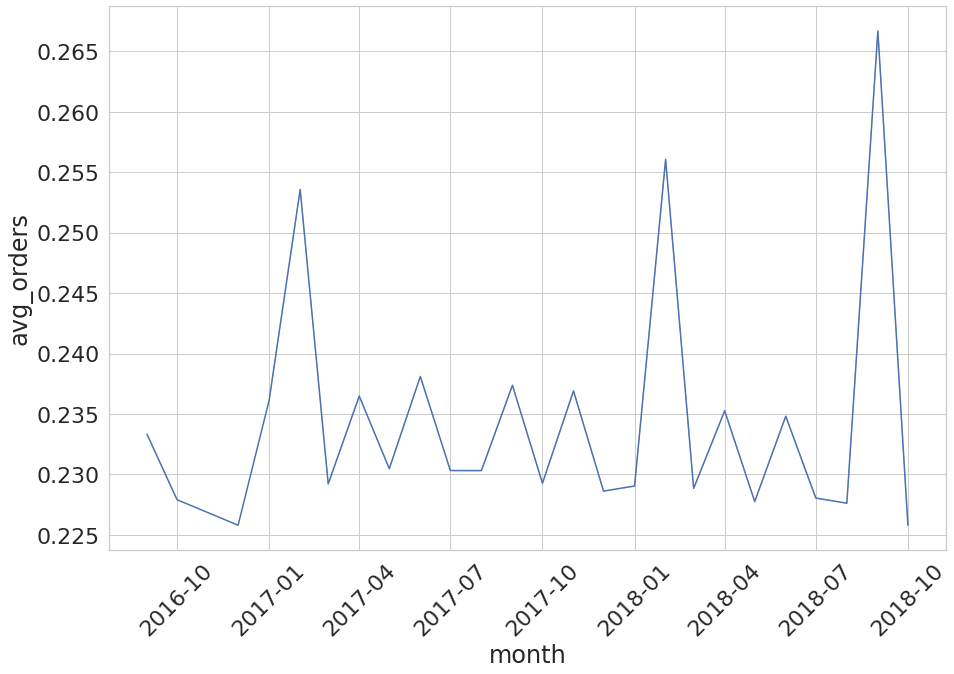

In [69]:
sns.lineplot(data=avg_order_by_week, x='month', y='avg_orders', ci=0)
ax.set(xlabel='Year and month', ylabel='Average orders count', title='Distribution of average monthly purchases')
plt.xticks(rotation=45)
plt.show()

## 5)Провести когортный анализ пользователей.

Нам необходимо для периода с `января` по `декабрь` выявить когорту с самым высоким `retention` на 3й месяц.

Т.к. никаких данных о регистрации пользователя нет, то мы будем считать датой регистрации время первой покупки. Объединим таблицу покупателей и заказов через left join, чтобы выяснить, сколько пользователей не заказывали товары совсем. Заказами без данных о покупателе, мы, напротив, можем принебречь.

In [70]:
customers_cohort = customers.merge(orders, on='customer_id', how='left')

In [71]:
customers_cohort.isna().sum()

customer_id                         0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_id                            0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
month                               0
day_of_week                         0
dtype: int64

In [72]:
print(f'Минимальный месяц - {customers_cohort.month.min()}, максимальный месяц - {customers_cohort.month.max()}')

Минимальный месяц - 2016-09, максимальный месяц - 2018-10


###### Нам необходимо найти когорту за период с `января` по `декабрь`. Исключим отмененные заказы и воспользуемся данными за весь 2017 год.

In [73]:
customers_cohort = customers_cohort.loc[(customers_cohort.month >= '2017-01') & 
                                        (customers_cohort.month <= '2017-12') &
                                        ~customers_cohort.order_status.isin(['unavailable', 'canceled'])]

###### Добавим месяц первой покупки для каждого пользователя, месяц текущей покупки уже хранится в колонке `month`.

In [74]:
a = customers_cohort \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'order_purchase_timestamp': 'min'}) \
    .rename(columns={'order_purchase_timestamp': 'first_order_month'})
customers_cohort = customers_cohort.merge(a, on='customer_unique_id')

In [75]:
customers_cohort['first_order_month'] = customers_cohort['first_order_month'].dt.strftime('%Y-%m')

In [76]:
customers_cohort.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month,day_of_week,first_order_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05,Tuesday,2017-05
1,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,89254,jaragua do sul,SC,5741ea1f91b5fbab2bd2dc653a5b5099,delivered,2017-09-14 18:14:31,2017-09-14 18:25:11,2017-09-18 21:27:40,2017-09-28 17:32:43,2017-10-04,2017-09,Thursday,2017-09
2,802bb9a59876a712f8380da8f297057c,4c93744516667ad3b8f1fb645a3116a4,89253,jaragua do sul,SC,98b737f8bd00d73d9f61f7344aadf717,delivered,2017-10-15 12:44:13,2017-10-15 13:05:29,2017-10-17 20:05:34,2017-10-25 17:00:04,2017-11-08,2017-10,Sunday,2017-09
3,5e274e7a0c3809e14aba7ad5aae0d407,57b2a98a409812fe9618067b6b8ebe4f,35182,timoteo,MG,1093c8304c7a003280dd34598194913d,delivered,2017-11-16 19:29:02,2017-11-16 19:55:41,2017-11-22 16:46:33,2017-11-27 12:44:36,2017-12-08,2017-11,Thursday,2017-11
4,9fb35e4ed6f0a14a4977cd9aea4042bb,2a7745e1ed516b289ed9b29c7d0539a5,39400,montes claros,MG,8428e578bb1cf839ae26a6b7615502b9,delivered,2017-11-27 17:23:20,2017-11-27 18:01:20,2017-11-28 23:04:41,2017-12-08 22:16:17,2017-12-20,2017-11,Monday,2017-11


In [77]:
def cohort_number_counter(data):
    data['cohort_month_number'] = np.arange(len(data)) + 1
    return data

In [78]:
customers_cohort = customers_cohort \
    .groupby(['first_order_month', 'month']) \
    .agg({'customer_unique_id': 'nunique'}) \
    .rename(columns={'customer_unique_id': 'count'})
customers_cohort.head()

count
first_order_month month         
2017-01           2017-01    753
                  2017-02      3
                  2017-03      2
                  2017-04      1
                  2017-05      3

In [79]:
cohort = customers_cohort.groupby('first_order_month').apply(cohort_number_counter)
#cohort = cohort.loc[cohort.cohort_month_number <= 3]
cohort.head()

count  cohort_month_number
first_order_month month                              
2017-01           2017-01    753                    1
                  2017-02      3                    2
                  2017-03      2                    3
                  2017-04      1                    4
                  2017-05      3                    5

In [80]:
cohort_size = customers_cohort['count'].groupby('first_order_month').first()

cohort_size.head()

first_order_month
2017-01     753
2017-02    1690
2017-03    2571
2017-04    2326
2017-05    3541
Name: count, dtype: int64

In [81]:
retention_data = customers_cohort['count'].unstack('first_order_month').T.divide(cohort_size, axis=0)
retention_data

month,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
first_order_month,,,,,,,,,,,,
2017-01,1.0,0.003984,0.002656,0.001328,0.003984,0.001328,0.003984,0.001328,0.001328,NaN,0.003984,0.001328
2017-02,NaN,1.000000,0.002367,0.002959,0.001183,0.004142,0.001183,0.002367,0.001775,0.001183,0.001775,0.001183
2017-03,NaN,NaN,1.000000,0.005056,0.003501,0.003890,0.003501,0.001556,0.001556,0.003112,0.003501,0.000778
2017-04,NaN,NaN,NaN,1.000000,0.006019,0.002150,0.001720,0.003009,0.002580,0.003439,0.003009,0.003009
2017-05,NaN,NaN,NaN,NaN,1.000000,0.004801,0.004801,0.003954,0.003106,0.003389,0.004236,0.001412
2017-06,NaN,NaN,NaN,NaN,NaN,1.000000,0.004513,0.003546,0.003868,0.002579,0.003868,0.003546
2017-07,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.005231,0.003400,0.002354,0.002877,0.002093
2017-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.006780,0.003390,0.002663,0.003632
2017-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.006869,0.005397,0.002944


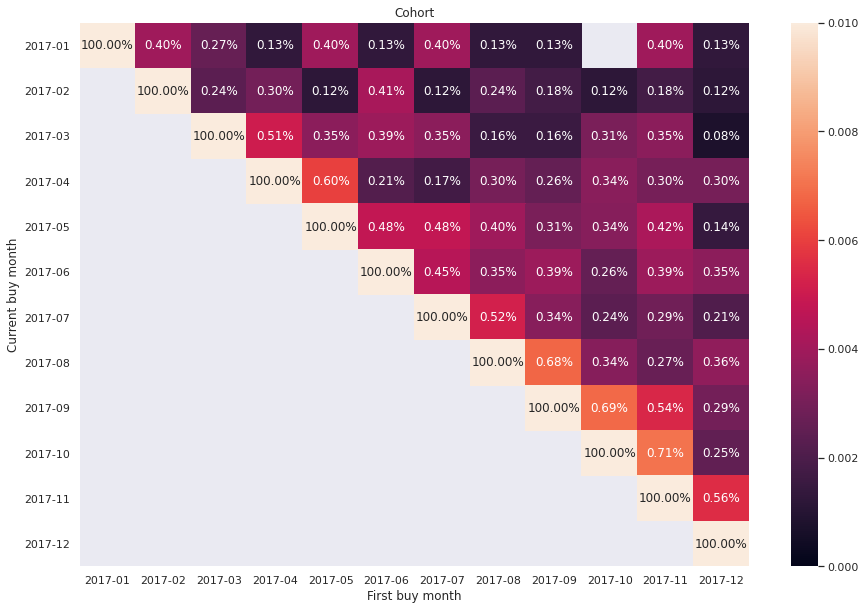

In [130]:
ax = sns.heatmap(retention_data, mask=retention_data.isnull(), annot=True, fmt='.2%', vmin=0.0, vmax=0.01)
ax.set(xlabel='First buy month', ylabel='Current buy month', title='Cohort')
sns.set(font_scale=1)
plt.show()

### Основываясь на данных, полученных от графика выше, мы можем определить, что на 3 месяц самый высокий `retention` был в сентябре 2017 года.

## 6)Построить RFM-сегментацию пользователей

#### В кластеризации будут выбраны следующие метрики: `R` - время от последней покупки пользователя до текущей даты, `F` - суммарное количество покупок у пользователя за всё время, `M` - сумма покупок за всё время

В качестве покупки мы, как и ранее, будем рассматривать время оформления заказа. Из-за предоставления устаревшей информации, за текущую дату мы примем последнюю дату покупки `"order_purchase_timestamp"` со смещением на 1 день вперед.

In [83]:
now = orders.order_purchase_timestamp.max() + datetime.timedelta(days=1)

In [84]:
delivered_orders = orders.loc[orders.customer_id.isin(id_uncancelled_orders)]

In [85]:
required_columns = ['order_id', 'product_id', 'price', 'order_purchase_timestamp']

In [86]:
items.shape

(112650, 7)

In [87]:
delivered_orders.shape

(98202, 10)

In [88]:
rfm_data = items.merge(delivered_orders, on='order_id', how='inner')

In [89]:
rfm_data = rfm_data.merge(customers, on='customer_id', how='inner')

In [90]:
rfm_data.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month,day_of_week,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,2017-09,Wednesday,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,2017-04,Wednesday,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,2018-01,Sunday,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,2018-08,Wednesday,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,2017-02,Saturday,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP


`R` - время от последней покупки пользователя до текущей даты, `F` - суммарное количество заказов у пользователя за всё время, `M` - сумма покупок за всё время.

In [91]:
temp_data = rfm_data.groupby('customer_unique_id', as_index=False) \
    .agg({'price': 'sum', 'order_id': 'nunique', 'order_purchase_timestamp': lambda x: (now - x.max()).days}) \
    .rename(columns={'order_id': 'frequency', 'price': 'monetary', 'order_purchase_timestamp': 'recency'})

In [92]:
temp_data.head()

,customer_unique_id,monetary,frequency,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90,1,161
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,1,164
2,0000f46a3911fa3c0805444483337064,69.00,1,586
3,0000f6ccb0745a6a4b88665a16c9f078,25.99,1,370
4,0004aac84e0df4da2b147fca70cf8255,180.00,1,337


In [93]:
quintiles = temp_data[['monetary', 'frequency', 'recency']].quantile([.2, .5, .95, .99]).to_dict()

Создадим функцию для подсчета `RFM`-значений.

In [94]:
def rfm_score(value, name):
    if value <= quintiles[name][.2]:
        return 1
    elif value <= quintiles[name][.5]:
        return 2
    elif value <= quintiles[name][.95]:
        return 3
    elif value <= quintiles[name][.99]:
        return 4
    else:
        return 5

In [95]:
temp_data['R'] = temp_data.recency.apply(lambda x: rfm_score(x, 'recency'))
temp_data['F'] = temp_data.frequency.apply(lambda x: rfm_score(x, 'frequency'))
temp_data['M'] = temp_data.monetary.apply(lambda x: rfm_score(x, 'monetary'))

In [96]:
temp_data['RFM_score'] = temp_data.R.map(str) + temp_data.F.map(str) + temp_data.M.map(str)

In [97]:
temp_data[['monetary', 'frequency', 'recency', 'RFM_score']].describe(percentiles=[.2, .4, .6, .8, .95, .99])

,monetary,frequency,recency
count,94983.000000,94983.000000,94983.000000
mean,142.071747,1.033859,287.960761
std,216.074999,0.210811,152.981551
min,0.850000,1.000000,45.000000
20%,39.900000,1.000000,142.000000
40%,69.900000,1.000000,227.000000
50%,89.890000,1.000000,269.000000
60%,109.900000,1.000000,318.000000
80%,179.900000,1.000000,433.000000
95%,420.000000,1.000000,570.000000


Меньшее значение `recency` и большее значение `frequency` и `monetary` более выгодны для компании. 

In [98]:
def get_info(segment):
    data = temp_data.loc[temp_data.segment == segment]
    monetary_min = data.loc[data.segment == segment].monetary.min()
    monetary_max = data.loc[data.segment == segment].monetary.max()
    recency_min = data.loc[data.segment == segment].recency.min()
    recency_max = data.loc[data.segment == segment].recency.max()
    frequency_min = data.loc[data.segment == segment].frequency.min()
    frequency_max = data.loc[data.segment == segment].frequency.max()
    print(f'RFM-сегмент {segment} имеет границы метрик:\n recency от {recency_min} до {recency_max} дней, ' +
          f'frequency от {frequency_min} до {frequency_max} заказов за все время, monetary от {np.round(monetary_min, 2)} ' +
          f'до {np.round(monetary_max, 2)} \n', '_' * 100)

In [99]:
len(temp_data.RFM_score.unique())

65

Из имеющихся данных мы получили 65 различных комбинаций RFM-значения.

Выделим основные сегменты:
 - `champions` - покупали не так давно, достаточно часто и тратили много денег
 - `loyal customers` - покупали чаще среднего, отзывчивы на рекламные акции
 - `hibernating` - давность выше среднего, совершали единоразовые покупки
 - `about to sleep` - давность ниже, а частота покупок выше среднего, потеряем, если не активируем повторно
 - `can't loose` - покупали не так давно, но нечасто 
 - `lost` - потерянные клиенты

In [100]:
segment_map = {
    r'[3-4][1-2]': 'hibernating',
    r'[1-2][14]': 'can\'t loose',
    r'[2][5]': 'about to sleep',
    r'[2-3][4-5]': 'loyal customers',
    r'5[1-5]': 'lost',
    r'4[1-5]': 'lost',
    r'15': 'champions'
}

temp_data['segment'] = temp_data['R'].map(str) + temp_data['F'].map(str)
temp_data['segment'] = temp_data['segment'].replace(segment_map, regex=True)
temp_data.head()

,customer_unique_id,monetary,frequency,recency,R,F,M,RFM_score,segment
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90,1,161,2,1,3,213,can't loose
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,1,164,2,1,1,211,can't loose
2,0000f46a3911fa3c0805444483337064,69.00,1,586,4,1,2,412,hibernating
3,0000f6ccb0745a6a4b88665a16c9f078,25.99,1,370,3,1,1,311,hibernating
4,0004aac84e0df4da2b147fca70cf8255,180.00,1,337,3,1,3,313,hibernating


In [101]:
for segment in temp_data['segment'].unique():
    get_info(segment) 

RFM-сегмент can't loose имеет границы метрик:
 recency от 45 до 269 дней, frequency от 1 до 2 заказов за все время, monetary от 0.85 до 7160.0 
 ____________________________________________________________________________________________________
RFM-сегмент hibernating имеет границы метрик:
 recency от 270 до 625 дней, frequency от 1 до 1 заказов за все время, monetary от 2.29 до 13440.0 
 ____________________________________________________________________________________________________
RFM-сегмент lost имеет границы метрик:
 recency от 571 до 773 дней, frequency от 1 до 6 заказов за все время, monetary от 3.9 до 2199.99 
 ____________________________________________________________________________________________________
RFM-сегмент loyal customers имеет границы метрик:
 recency от 270 до 569 дней, frequency от 2 до 5 заказов за все время, monetary от 22.8 до 7388.0 
 ____________________________________________________________________________________________________
RFM-сегмент abo

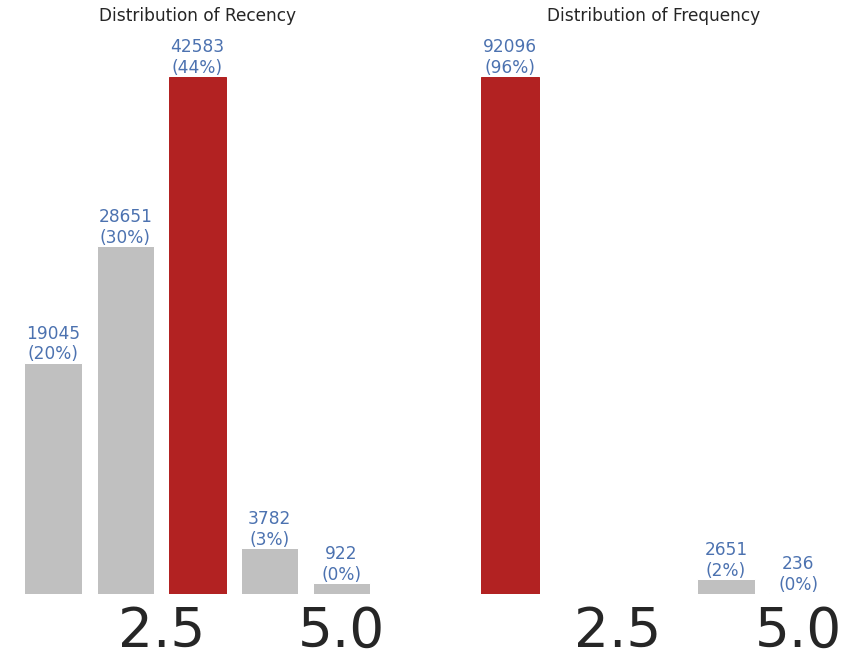

In [102]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Recency', 'F':'Frequency'}
    y = temp_data[p].value_counts().sort_index()
    x = y.index #понятия не имею, почему на оси x отображаются не все оси
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=17, pad=30.0)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='bottom',
               color='b',
               fontsize=17.0)

plt.show()

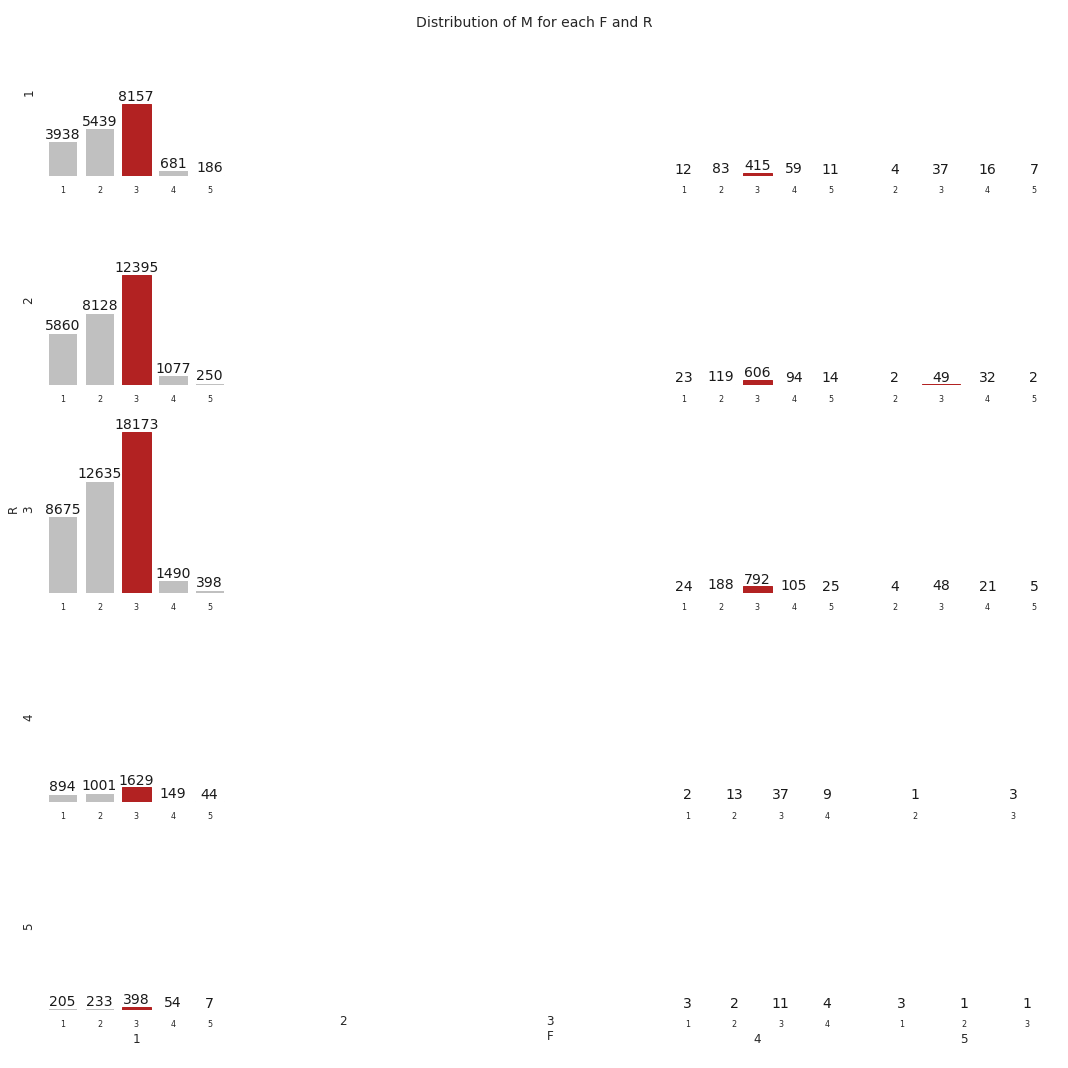

In [129]:
fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(15, 15))

r_range = range(1, 6)
f_range = range(1, 6)
for r in r_range:
    for f in f_range:
        y = temp_data[(temp_data['R'] == r) & (temp_data['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    fontsize=14,
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.show()

### На основе полученных данных мы можем сделать вывод, что исследуемая компания имеет явные проблемы с удержанием клиентов. Необходимо любой ценой поднять `retention`.